## PyTorch Multi-Layer Perceptron (MLP) Image Classifier With Fashion MNIST Dataset

In this example, we will train an MLP model to classify images from the Fashion MNIST database.

The Fashion MNIST dataset is a widely used dataset in Deep Learning for training and testing various algorithms. It was created as a replacement for the original handwritten digits MNIST dataset to provide a more challenging classification task.

Here are some key details about the Fashion MNIST dataset:
- The dataset consists of 70,000 grayscale images of fashion products from 10 different categories
- Each image is a 28x28 pixel square
- The dataset consists of a training dataset of 60,000 images and a test dataset of 10,000 images
- In this example, the test dataset is divided into validation and test sets, each containing 5,000 samples.

The goal is to classify each image into one of the 10 fashion categories, such as T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot

<img src='https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/mlp_fmnist.png'>


References:
- [Image Classifier using PyTorch and Keras](https://medium.com/dataseries/image-classifier-using-pytorch-and-keras-555007a50c2e)

- [Basic Syntax of the Markdown elements.](https://www.markdownguide.org/basic-syntax/)

- Fashion-MNIST: https://github.com/zalandoresearch/fashion-mnist

# Starting of your code

In [1]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq

In [2]:
# Import the necessary libraries for working with Fashion-MNIST dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import sys
import time
import pickle

In [3]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python version: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python version: (3, 12, 12)
PyTorch version: 2.10.0+cu130
Device: cuda


In [4]:
# Set seed for reproducibility
# Students are required to use the last 4 digits of the student ID card as the seed number for Assignment 1 submission
seed = 1339
torch.manual_seed(seed)

# Download Fashion MNIST Dataset

This code snippet creates DataLoaders to facilitate the downloading of the training and test sets. The Fashion MNIST training dataset, consisting of 60,000 samples, is used to train the Model. The test dataset is randomly split into a validation set and a test set, each containing 5,000 samples. The data loaders are employed to provide batches of data from the datasets for iteration. The training data comprises batches of images, with each image measuring 28 x 28 pixels. The corresponding labels indicate the correct Fashion labels ("T-shirt," "Trouser," "Pullover," etc.) for each image.

In [5]:
# Define data transformations for the training and test sets
train_transform = transforms.Compose([
     transforms.RandomHorizontalFlip(p=0.18),  # Randomly flip image horizontally with probability 0.2
     transforms.RandomAffine(0, translate=(0.01, 0.028), scale=(0.9, 1.1)),  # Randomly translate and scale the image
     transforms.ToTensor(),  # Convert images to tensors
     transforms.Normalize((0.2860,), (0.3530,))])  # Normalize the image data

test_transform = transforms.Compose([
     transforms.ToTensor(),  # Convert images to tensors
     transforms.Normalize((0.2860,), (0.3530,))])  # Normalize the image data

# Create the Fashion MNIST dataset for the training set with 60,000 images
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)

# Create the Fashion MNIST dataset for the test set with 10,000 images
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

g = torch.Generator()
g.manual_seed(seed)
# Split the original test set into a validation set with 5,000 samples and a test set with 5,000 samples
val_set, test_set = torch.utils.data.random_split(test_dataset, [5000, 5000])

# pin_memory speeds up host->GPU copies (CUDA only)
pin_memory = (device == "cuda")

# Define the data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8, pin_memory=pin_memory, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8, pin_memory=pin_memory, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8, pin_memory=pin_memory, persistent_workers=True)

# Define the classes for the Fashion MNIST dataset
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

##Visualize image for each class
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

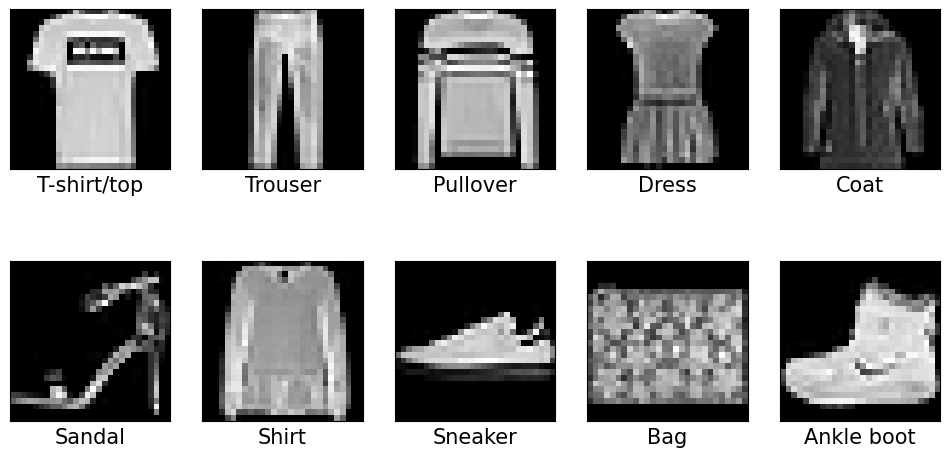

In [6]:
# Visualize training image for each class
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i], cmap='gray')
    i += 1

# Define the MLP Network Architecture

The following code defines a class called MLP which inherits from nn.Module. The network has 4 fully-connected hidden layers and one output layer:

- fc1 takes the 784-pixel Fashion MNIST image as input and outputs 144 nodes, followed by batch normalization and a GELU activation.

- fc2 takes the 144 nodes and outputs 128 nodes, again with batch normalization and a GELU activation.

- fc3 is a residual block: it takes the 128 nodes, applies batch normalization, a Linear(128 → 128) layer, GELU activation and dropout, and then adds the original input (identity skip connection).

- fc4 takes the 128 nodes and outputs another 128 nodes, with batch normalization and a GELU activation.

- fc_out takes the 128 nodes and outputs predictions for the 10 classes (raw logits without activation).

The forward method defines the forward pass through the network. It flattens the 28×28 image into a 784-dimensional vector, then passes it through fc1, fc2, the residual block fc3, fc4, and finally the output layer.


In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # fc1: 784 -> 144
        self.fc1 = nn.Linear(784, 144)
        self.bn1 = nn.BatchNorm1d(144)

        # fc2: 144 -> 128
        self.bn2 = nn.BatchNorm1d(144)
        self.fc2 = nn.Linear(144, 128)

        # fc3: 128 -> 128 + residual
        self.bn3 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 128)

        # fc4: 128 -> 128
        self.bn4 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 128)

        # output: 128 -> 10
        self.fc_out = nn.Linear(128, 10)

        # activation function (GELU)
        self.activation = nn.GELU()
        
        # dropout layer with rate 0.3
        self.dropout = nn.Dropout(0.3)

        # initialize weights and biases
        self._initialize_weights()


    # helper to initialize weights and biases
    def _initialize_weights(self):
        # loop over all submodules in this network
        for m in self.modules():
            # for Linear layers, use Kaiming normal initialization
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                # set bias of Linear layers to zero (if present)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            # for BatchNorm1d layers, set scale to 1 and bias to 0
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)


    def forward(self, x):
        x = x.view(-1, 784)

        # fc1: 784 -> 144 (Linear -> BN -> GELU)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)

        # fc2: 144 -> 128 (BN -> Linear -> GELU)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.activation(x)

        # fc3: 128 -> 128 + residual (BN -> Linear -> GELU -> Dropout)
        res = x
        x = self.bn3(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = x + res

        # fc4: 128 -> 128 (BN -> Linear -> GELU)
        x = self.bn4(x)
        x = self.fc4(x)
        x = self.activation(x)
        
        # output logits for 10 classes
        return self.fc_out(x)


In [8]:
model = MLP()

## Print the Model Structure and Number of Parameters

In [9]:
from torchinfo import summary

def grouped_summary(model):
    info = summary(
        model=model,
        input_size=(1, 1, 28, 28),
        col_width=15,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'],
        verbose=0,
    )

    text = str(info)
    lines = text.splitlines()

    new_lines = []
    first_linear_seen = False

    for line in lines:
        stripped = line.lstrip()

        # when encountering a new Linear layer (from the second one onward),
        # insert a blank line before it to visually separate major blocks
        if stripped.startswith("├─Linear"):
            if first_linear_seen and new_lines and new_lines[-1] != "":
                new_lines.append("")  # blank line to mark a new "block"
            first_linear_seen = True

        new_lines.append(line)

    print("\n".join(new_lines))

# call this instead of using summary(...) directly
grouped_summary(MLP())

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
MLP (MLP)                                [1, 1, 28, 28]  [1, 10]         --              True
├─Linear (fc1)                           [1, 784]        [1, 144]        113,040         True
├─BatchNorm1d (bn1)                      [1, 144]        [1, 144]        288             True
├─GELU (activation)                      [1, 144]        [1, 144]        --              --
├─BatchNorm1d (bn2)                      [1, 144]        [1, 144]        288             True

├─Linear (fc2)                           [1, 144]        [1, 128]        18,560          True
├─GELU (activation)                      [1, 128]        [1, 128]        --              --
├─BatchNorm1d (bn3)                      [1, 128]        [1, 128]        256             True

├─Linear (fc3)                           [1, 128]        [1, 128]        16,512          True
├─GELU (activation)                      [1, 128]        

## Specify Loss Function and Optimizer
It's recommended that you use cross-entropy loss for classification. If you look at the documentation, you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [10]:
# Specify loss function (categorical cross-entropy with label smoothing = 0.01)
criterion = nn.CrossEntropyLoss(label_smoothing=0.01)

# Separate parameters: apply weight decay only to non-BatchNorm, non-bias parameters
decay, no_decay = [], []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue                          # skip frozen parameters
    if name.endswith(".bias") or "bn" in name.lower():
        no_decay.append(param)              # no weight decay for bias and BatchNorm
    else:
        decay.append(param)              # apply weight decay for all other weights


# Specify optimizer (AdamW) with weight decay = 0.13 for non-BN/bias params, lr = 0.0005
optimizer = optim.AdamW([
    
    {"params": decay, "weight_decay": 0.19}, 
    {"params": no_decay, "weight_decay": 0.0}
    ],
        
    lr=0.0005, betas=(0.9, 0.999), eps=1e-08
    )

# Specify learning rate scheduler (CosineAnnealingLR, single cycle over 120 epochs, min lr = 1e-7)
EPOCHS = 120
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=2e-8)

##Training the Network
The steps for training/learning from a batch of data are described in the comments below:

Clear the gradients of all optimized variables Forward pass: compute predicted outputs by passing inputs to the model Calculate the loss Backward pass: compute gradient of the loss with respect to model parameters Perform a single optimization step (parameter update) Update average training loss The following loop trains for 100 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [11]:
# Create a Models folder to store the checkpoints
!mkdir Models

A subdirectory or file Models already exists.


In [12]:
# EPOCHS is defined in the scheduler cell above

loss_hist, acc_hist = [], []            # training loss / acc per epoch
loss_hist_val, acc_hist_val = [], []    # validation loss / acc per epoch
best_acc_val = 0.0                      # best validation accuracy so far
best_epoch = 0                          # epoch index of the best val accuracy

model.to(device)  # Move the model to the specified device (e.g., GPU)

print("Training was started.\n")
time_total_start = time.time()

# Helper: format learning rate in full decimal form (no scientific notation)
def format_lr(lr: float) -> str:
    s = f"{lr:.10f}"
    s = s.rstrip("0").rstrip(".")
    if s == "0":
        s = "0.0"
    return s

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print("EPOCH:", epoch, end=" ")
    running_loss = 0.0
    correct = 0

    # Training loop
    model.train()
    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # Clear the gradients
        outputs = model(batch)                 # Forward pass
        loss = criterion(outputs, labels)      # Compute the loss

        loss.backward()                        # Backward pass (compute gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        optimizer.step()                       # Update the model's parameters

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)  # Average training loss for the epoch
    avg_acc = correct / len(train_set)           # Average training accuracy for the epoch
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        loss_val = 0.0
        correct_val = 0

        for data in val_loader:
            batch, labels = data
            batch, labels = batch.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(batch)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            loss_val += loss.item()

        avg_loss_val = loss_val / len(val_loader)   # Average validation loss
        avg_acc_val = correct_val / len(val_set)    # Average validation accuracy
        loss_hist_val.append(avg_loss_val)
        acc_hist_val.append(avg_acc_val)

    model.train()       # Set the model back to training mode
    scheduler.step()    # Update the learning rate scheduler

    current_lr = optimizer.param_groups[0]["lr"]

    # Track best validation accuracy
    is_best = avg_acc_val > best_acc_val
    if is_best:
        best_acc_val = avg_acc_val
        best_epoch = epoch

    # Save the model at the end of each epoch
    with open(f"Models/MLP_model_{epoch}.pth", "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    # Print training statistics
    print(f"LR: {format_lr(current_lr)}", end=" ")
    print("Train Loss: {:.4f}".format(avg_loss), end=" ")
    print("Val Loss: {:.4f}".format(avg_loss_val), end=" ")
    print("Train Acc: {:.2f}%".format(avg_acc * 100), end=" ")
    print("Val Acc: {:.2f}%".format(avg_acc_val * 100), end=" ")
    print("Time: {:.2f}s".format(time.time() - time_ckpt), end="")
    if is_best:
        print(" Best!", end="")
    print()  # new line

time_total = time.time() - time_total_start
print(f"\n✓ Training completed! Best val acc: {best_acc_val*100:.2f}% at epoch {best_epoch}")
print("Per-epoch checkpoints saved in Models/MLP_model_{epoch}.pth")
print(f"Total training time: {time_total:.2f}s ({time_total/60:.2f} min)")

Training was started.

EPOCH: 1 LR: 0.0004999143 Train Loss: 0.6815 Val Loss: 0.5074 Train Acc: 77.46% Val Acc: 82.84% Time: 11.54s Best!
EPOCH: 2 LR: 0.0004996574 Train Loss: 0.5034 Val Loss: 0.4380 Train Acc: 83.68% Val Acc: 85.56% Time: 3.04s Best!
EPOCH: 3 LR: 0.0004992294 Train Loss: 0.4686 Val Loss: 0.4224 Train Acc: 85.02% Val Acc: 86.50% Time: 3.07s Best!
EPOCH: 4 LR: 0.0004986305 Train Loss: 0.4450 Val Loss: 0.4245 Train Acc: 85.84% Val Acc: 86.50% Time: 3.03s
EPOCH: 5 LR: 0.0004978613 Train Loss: 0.4304 Val Loss: 0.3980 Train Acc: 86.26% Val Acc: 87.32% Time: 2.93s Best!
EPOCH: 6 LR: 0.0004969222 Train Loss: 0.4195 Val Loss: 0.3962 Train Acc: 86.77% Val Acc: 87.50% Time: 2.86s Best!
EPOCH: 7 LR: 0.0004958139 Train Loss: 0.4084 Val Loss: 0.3823 Train Acc: 87.01% Val Acc: 88.06% Time: 2.82s Best!
EPOCH: 8 LR: 0.0004945371 Train Loss: 0.3989 Val Loss: 0.3841 Train Acc: 87.54% Val Acc: 87.80% Time: 2.78s
EPOCH: 9 LR: 0.0004930928 Train Loss: 0.3940 Val Loss: 0.3738 Train Acc: 87.

## Plotting Training Statistics

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time. Accuracy is the classification accuracy for the test data.

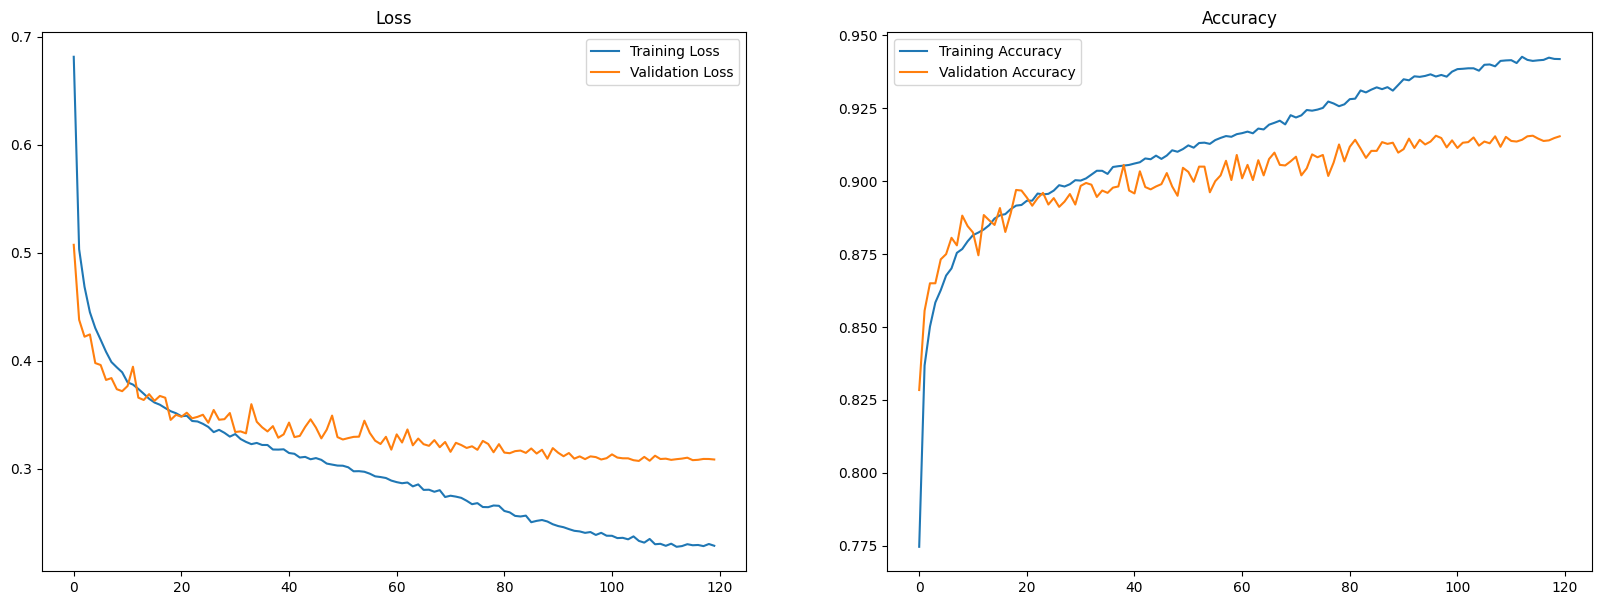

In [13]:
plots=[(loss_hist,loss_hist_val),(acc_hist,acc_hist_val)]
plt_labels=[("Training Loss","Validation Loss"),("Training Accuracy","Validation Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

In [14]:
# Selecting the best model
best_acc = max(acc_hist_val)
best_epoch = acc_hist_val.index(best_acc) + 1

print("Best accuracy on validation set: {:.2f}%".format(best_acc * 100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Models/MLP_model_{best_epoch}.pth", "rb") as f:
    model = pickle.load(f)

Best accuracy on validation set: 91.56%
Best epoch: 97


In [15]:
pred_vec = []
label_vec = []
correct = 0

model.to(device)
model.eval()

test_loss_sum = 0.0   # accumulate loss * batch_size over all batches
test_samples = 0      # total number of samples

with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        outputs = model(batch)
        loss = criterion(outputs, labels)

        # accumulate loss for weighted average
        batch_size = labels.size(0)
        test_loss_sum += loss.item() * batch_size
        test_samples += batch_size

        # accumulate correct predictions and store predictions/labels
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.extend(predicted.cpu().numpy())
        label_vec.extend(labels.cpu().numpy())

# compute average loss over the whole test set
test_loss = test_loss_sum / test_samples

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)

print("Test Loss: {:.2f}".format(test_loss))
print('Test set Accuracy on the 5,000 test images: %.2f %%' % (100 * correct / len(test_set)))

Test Loss: 0.30
Test set Accuracy on the 5,000 test images: 92.02 %


# Display the Confusion Matrix

In [16]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,437,0,3,8,2,1,49,0,3,0
Trouser,0,476,1,3,0,0,1,0,0,0
Pullover,4,0,440,6,24,0,28,0,1,0
Dress,9,3,3,463,13,0,9,0,2,0
Coat,0,1,25,11,449,0,22,0,0,0
Sandal,0,0,0,0,0,505,0,5,0,3
Shirt,50,0,32,12,29,0,372,0,3,0
Sneaker,0,0,0,0,0,2,0,488,0,10
Bag,1,0,1,2,1,1,0,1,497,0
Ankle boot,0,0,0,0,0,1,0,13,0,474


# Compute the Accuracy, F1-Score, Precision, Recall, Support

In [17]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(
    classification_report(label_vec, pred_vec, output_dict=True, digits=4)
).T
report["Label"] = [classes[int(x)] if x.isdigit() else " " for x in report.index]
report = report[["Label", "f1-score", "precision", "recall", "support"]]
report

,Label,f1-score,precision,recall,support
0,T-shirt/top,0.870518,0.872255,0.868787,503.0000
1,Trouser,0.990635,0.991667,0.989605,481.0000
2,Pullover,0.873016,0.871287,0.874751,503.0000
3,Dress,0.919563,0.916832,0.922311,502.0000
4,Coat,0.875244,0.866795,0.883858,508.0000
5,Sandal,0.987292,0.990196,0.984405,513.0000
6,Shirt,0.759959,0.773389,0.746988,498.0000
7,Sneaker,0.969215,0.962525,0.976000,500.0000
8,Bag,0.984158,0.982213,0.986111,504.0000
9,Ankle boot,0.972308,0.973306,0.971311,488.0000


# Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

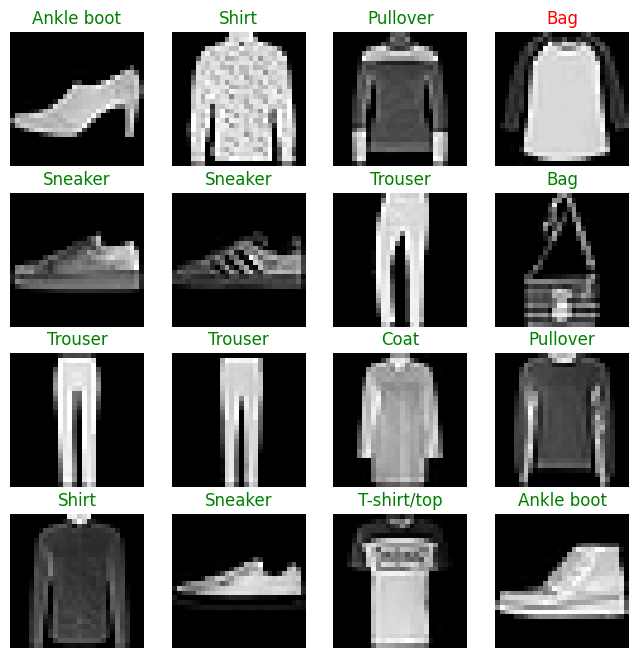

In [18]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
  # Normalize the image tensor to [0, 1] range
  image = images[idx].permute(1, 2, 0)
  image = (image - image.min()) / (image.max() - image.min())
  ax.imshow(image, cmap='gray')  # Display the image
  ax.axis('off')  # Hide the axes
  ax.set_title("{}".format(classes[preds[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))  # Add title to the image
plt.show()

#Display 50 Predicted Images in Reversed Grayscale
We iterate through 50 images and plot them with their corresponding label. We will color the label in blue if our model guessed correct and in red if it failed to predict that class.

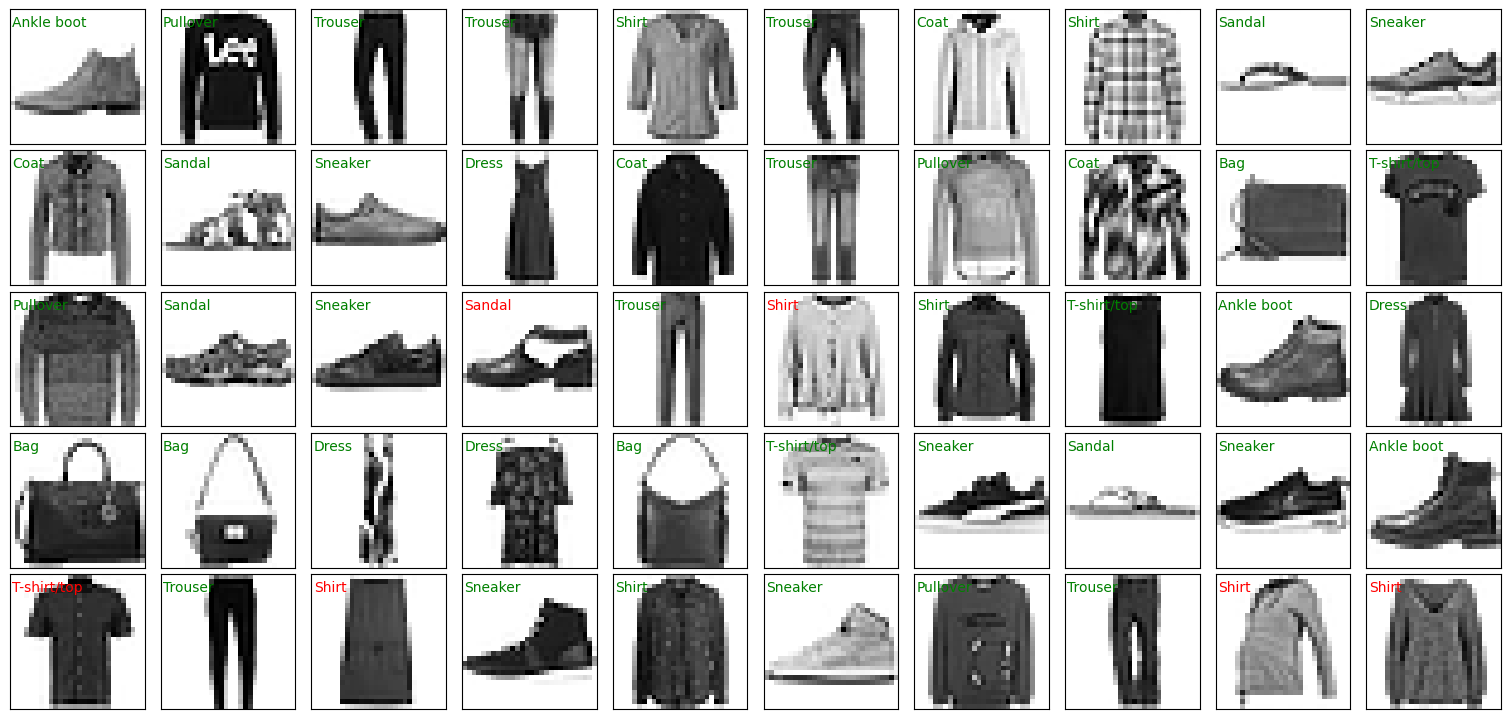

In [19]:
# Define the loader for all test data
# pin_memory speeds up host->GPU copies (CUDA only)
pin_memory = (device == "cuda")
test_set_all = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False, transform=test_transform)
test_loader_all = torch.utils.data.DataLoader(test_set_all, batch_size=128, shuffle=False, num_workers=2, pin_memory=pin_memory)


# obtain one batch of test images
dataiter = iter(test_loader_all)
images, labels = next(iter(test_loader_all))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for idx in range(50):
    # Normalize the image tensor to [0, 1] range
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax = fig.add_subplot(5, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

    if preds[idx]==labels[idx]:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='green')
    else:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='red')

plt.show()

#Visualize wrongly classified image for each class

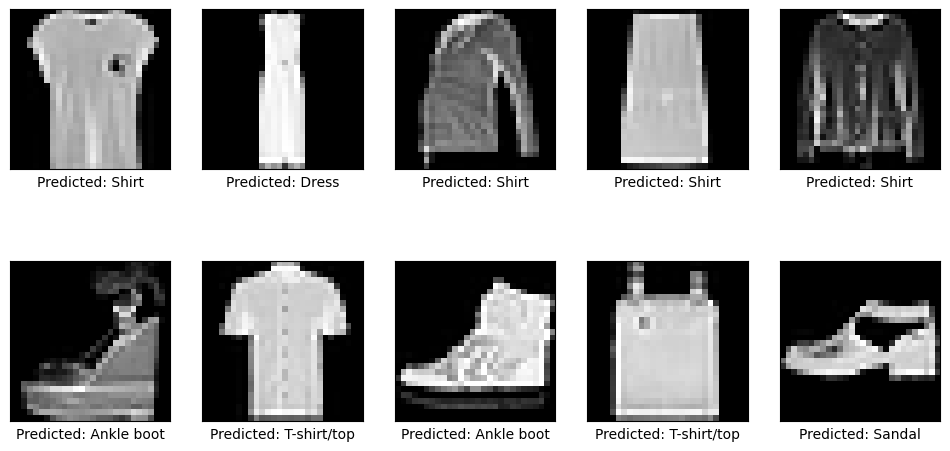

In [20]:
# Visualize wrongly classified image for each class


pred_vec_all = []
correct = 0
test_loss = 0.0

model.to(device)

with torch.no_grad():
    for data in test_loader_all:
        batch, labels = data
        batch, labels = batch.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(batch)
        test_loss=criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec_all.append(predicted)
    pred_vec_all = torch.cat(pred_vec_all)

pred_vec_all = pred_vec_all.cpu().numpy()
ground_truths = np.asarray(test_set_all.targets)
incorrect_mask = pred_vec_all != ground_truths
incorrect_images = [test_set_all.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results_all = [pred_vec_all[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results_all[i]], fontsize=10)
    axis.imshow(incorrect_images[i], cmap='gray')
    i += 1

# Assignment 1: Summary Report

This report summarizes the improvements made to the baseline Fashion-MNIST MLP classifier, including model architecture design, training process, experimental results, evaluation, and conclusions. The goal is to improve test performance and generalization while maintaining stable and efficient training.

### **1. Model Architecture Design**

I evolved the architecture from a shallow network to a deeper, regularized MLP with residual connections.

*   **Layer Topology (Depth & Width)**
    *   **Baseline:** `784 → 128 → 64 → 10` (3 Layers)
    *   **Final:** `784 → 144 → 128 → 128 (ResBlock) → 128 → 10` (5 Layers)
    *   *Improvement:* Increased depth and width allow the model to learn more complex feature representations from the flattened images.

*   **Activation Function**
    *   **Baseline:** `Sigmoid`
    *   **Final:** `GELU` (Gaussian Error Linear Unit)
    *   *Improvement:* **Sigmoid** suffers from the vanishing gradient problem in deeper networks. **GELU** is non-saturating, enabling faster convergence and better gradient flow.

*   **Normalization (New Addition)**
    *   **Baseline:** None
    *   **Final:** `BatchNorm1d`
    *   *Improvement:* **Pre-norm** for fc2–fc4 (BN before each linear layer) and **post-norm** for fc1 (BN after the first linear layer). This reduces internal covariate shift, stabilizes training, and allows a higher learning rate.

*   **Structural Enhancements (New Additions)**
    *   **Residual Connection:** A skip connection (`x = x + f(x)`) was added to the third layer. This prevents performance degradation in deeper networks by allowing gradients to flow directly through the network.
    *   **Dropout:** A dropout layer (`p=0.3`) was integrated within the residual block (fc3) only to prevent overfitting by randomly zeroing out neurons during training.

*   **Weight Initialization (New Addition)**
    *   **Baseline:** PyTorch Default (Uniform)
    *   **Final:** `Kaiming Normal` (He Initialization)
    *   *Improvement:* Explicitly initialized weights to match the non-linearity of GELU, ensuring a stable starting point for gradients in a deeper network.

*   **Output Layer**
    *   **Baseline:** `LogSoftmax`
    *   **Final:** Raw Logits (Linear Output)
    *   *Improvement:* Removed the activation from the final layer to work directly with `CrossEntropyLoss`, improving numerical stability during loss calculation.


### **2. Training Process**

I updated the training pipeline with a modern optimizer, scheduling, loss, and data setup to improve convergence and generalization.

*   **Optimizer**
    *   **Baseline:** `SGD` with `lr=0.01`, no weight decay.
    *   **Final:** `AdamW` with lr=0.0005, weight decay 0.19 and grouped weight decay (no decay on BatchNorm or bias).
    *   *Improvement:* **AdamW** gives faster and more stable convergence; grouped weight decay regularizes only Linear weights and avoids harming BatchNorm/bias.

*   **Learning Rate Schedule**
    *   **Baseline:** Fixed learning rate 0.01 (no scheduler)
    *   **Final:** `CosineAnnealingLR` over the full run (T_max=120, eta_min=2e-8)
    *   *Improvement:* Smooth decay improves late-stage fine-tuning and leads to better generalization than a fixed learning rate.

*   **Loss Function**
    *   **Baseline:** `CrossEntropyLoss` with no label smoothing
    *   **Final:** `CrossEntropyLoss` with label smoothing 0.01
    *   *Improvement:* Label smoothing reduces overconfident predictions and improves calibration and test accuracy.

*   **Gradient Clipping (New Addition)**
    *   **Baseline:** None
    *   **Final:** `clip_grad_norm_` with max_norm=1.0
    *   *Improvement:* Limits gradient explosion and stabilizes training, especially with deeper networks and residual connections.

*   **Data Augmentation**
    *   **Baseline:** None
    *   **Final:** `RandomHorizontalFlip` (p=0.18); `RandomAffine` with translate=(0.01, 0.028) and scale=(0.9, 1.1).
    *   *Improvement:* Light augmentation increases invariance to small shifts and scale, improving robustness and generalization without heavy distortion.

*   **Input Normalization**
    *   **Baseline:** `Normalize((0.5,), (0.5,))`
    *   **Final:** Dataset-specific `Normalize(mean=0.2860, std=0.3530)` (Fashion-MNIST statistics)
    *   *Improvement:* Matching the data distribution speeds up convergence and stabilizes BatchNorm.

*   **Data Loader & Efficiency**
    *   **Baseline:** batch_size=256, num_workers=2; no pin_memory or persistent_workers
    *   **Final:** batch_size=128, num_workers=8, pin_memory=True, persistent_workers=True; `optimizer.zero_grad(set_to_none=True)`
    *   *Improvement:* Better GPU utilization and less per-epoch overhead (e.g. per-epoch time reduced from ~6.4s to ~2.8s).


### **3. Experimental Results**

The improved model achieved significant gains across all metrics, demonstrating better generalization and robustness.

*   **Test Accuracy**
    *   **Baseline:** 80.40%
    *   **Final:** 92.02%
    *   *Improvement:* Absolute improvement of +11.62%, indicating substantially better generalization on unseen test data.

*   **Validation Accuracy**
    *   **Baseline:** 80.44% (best)
    *   **Final:** 91.56% (best at epoch 97)
    *   *Improvement:* Consistent improvement throughout training, with best validation accuracy reached at epoch 97, showing stable convergence.

*   **Test Loss**
    *   **Baseline:** 0.69
    *   **Final:** 0.30
    *   *Improvement:* Reduced by 56.5%, indicating improved confidence calibration and better generalization.


### **4. Evaluation**

I evaluated the model using comprehensive metrics and error analysis to understand generalization and remaining limitations.

*   **Evaluation Metrics**
    *   **Baseline:** Accuracy, test loss, and per-class metrics (with bug in `classification_report`)
    *   **Final:** Accuracy, test loss, per-class precision/recall/F1, macro and weighted F1 averages
    *   *Improvement:* Comprehensive metrics provide a complete picture of model performance across all classes and overall generalization.

*   **F1 Score (Macro Average)**
    *   **Baseline:** 0.799
    *   **Final:** 0.920
    *   *Improvement:* Improved by 15.1%, showing balanced performance across all classes.

*   **F1 Score (Weighted Average)**
    *   **Baseline:** 0.808
    *   **Final:** 0.920
    *   *Improvement:* Improved by 13.9%, demonstrating robust performance across class distributions.

*   **Hard Class Performance**
    *   **Baseline:** "Shirt" class F1 = 0.43
    *   **Final:** "Shirt" class F1 = 0.76
    *   *Improvement:* The most difficult class improved by 76.7%, showing the model's enhanced ability to discriminate visually similar categories.

*   **Metrics Correctness (Bug Fix)**
    *   **Baseline:** `classification_report` was called with reversed arguments `(y_pred, y_true)` instead of `(y_true, y_pred)`, causing incorrect precision/recall/F1
    *   **Final:** Correct argument order `(y_true, y_pred)`
    *   *Improvement:* All reported precision, recall, and F1 values are now valid and comparable across runs.



### **5. Conclusions**

I summarize the key findings, effective techniques, and remaining limitations from this work.

*   **Key Techniques That Worked Well**
    *   **Architecture:** The combination of **BatchNorm + residual connection + GELU** provided trainability and stability, enabling deeper networks without degradation.
    *   **Optimization:** **AdamW + cosine annealing** delivered better optimization dynamics and convergence compared to SGD with fixed learning rate.
    *   **Generalization:** **Data augmentation + label smoothing** improved robustness and reduced overconfidence, contributing to better test performance.
    *   *Impact:* These improvements jointly increased test accuracy from 80.40% to 92.02% and reduced test loss from 0.69 to 0.30.

*   **Balanced Class Improvements**
    *   **Baseline:** Macro F1 = 0.799, weighted F1 = 0.808; hardest class "Shirt" F1 = 0.43
    *   **Final:** Macro F1 = 0.920, weighted F1 = 0.920; "Shirt" F1 = 0.76
    *   *Improvement:* The model significantly raised macro/weighted F1 and notably strengthened the hardest class (76.7% improvement), showing improved robustness beyond simply boosting easy categories.

*   **Remaining Limitations**
    *   **Main Issue:** Most residual errors come from confusion between **Shirt / T-shirt/top / Pullover / Coat** (upper-body categories with similar textures/silhouettes)
    *   **Root Cause:** MLP architecture lacks spatial inductive bias, making it difficult to capture local texture patterns that distinguish these visually similar categories
    *   *Future Direction:* Convolutional architectures (CNN) or vision transformers would better handle local spatial features and likely improve discrimination among these challenging classes.